# 2-D Gaussian Distribution and HMC, SGHMC, SGLD, ...

In [1]:
import os
import sys
from jax.config import config
import jax
from jax import numpy as jnp
import numpy as onp
import time
import tqdm
import optax
import functools
from matplotlib import pyplot as plt

from bnn_hmc.utils import losses
from bnn_hmc.utils import train_utils
from bnn_hmc.utils import tree_utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Define distribution

In [2]:
mu = jnp.zeros([2,])
sigma = jnp.array([[1., .5], [.5, 1.]])
sigma_l = jnp.linalg.cholesky(sigma)
sigma_inv = jnp.linalg.inv(sigma)
sigma_det = jnp.linalg.det(sigma)

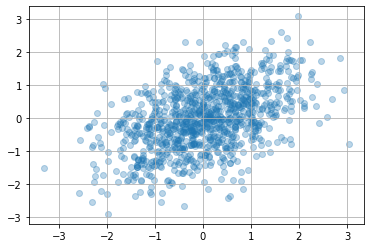

In [3]:
samples = onp.random.multivariate_normal(onp.asarray(mu), onp.asarray(sigma), size=1000)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.3)
plt.grid()

In [4]:
# def fake_model_forward(params, _, _, _, _):
#     return params, None

In [5]:
def log_density_fn(params):
    assert params.shape == mu.shape, "Shape error"
    diff = params - mu
    
    k = mu.size
    
    log_density = -jnp.log(2 * jnp.pi) * k / 2
    log_density -= jnp.log(sigma_det) / 2
    log_density -= diff.T @ sigma_inv @ diff / 2
    return log_density
    
    

In [6]:
def log_likelihood_fn(_, params, *args, **kwargs):
    return log_density_fn(params), jnp.array(jnp.nan)

def log_prior_fn(_):
    return 0.

def log_prior_diff_fn(*args):
    return 0.
    

In [7]:
fake_net_apply = None
fake_data = jnp.array([[jnp.nan,],]), jnp.array([[jnp.nan,],])
fake_net_state = jnp.array([jnp.nan,])

## HMC

In [19]:
step_size = 1e-1
trajectory_len = jnp.pi / 2
max_num_leapfrog_steps = int(trajectory_len // step_size + 1)
print("Leapfrog steps per iteration:", max_num_leapfrog_steps)

Leapfrog steps per iteration: 16


In [20]:
update, get_log_prob_and_grad = train_utils.make_hmc_update(
    fake_net_apply, log_likelihood_fn, log_prior_fn, log_prior_diff_fn,
    max_num_leapfrog_steps, 1., 0.)

In [21]:
# Initial log-prob and grad values
# params = jnp.ones_like(mu)[None, :]
params = jnp.ones_like(mu)
log_prob, state_grad, log_likelihood, net_state = (
    get_log_prob_and_grad(fake_data, params, fake_net_state))

In [22]:
log_prob, state_grad, log_likelihood, net_state

(DeviceArray(-2.3607028, dtype=float32),
 DeviceArray([-0.6666667, -0.6666667], dtype=float32),
 DeviceArray(-2.3607028, dtype=float32),
 ShardedDeviceArray([nan], dtype=float32))

In [23]:
num_iterations = 500
all_samples = []
key = jax.random.PRNGKey(0)

for iteration in tqdm.tqdm(range(num_iterations)):

    (params, net_state, log_likelihood, state_grad, step_size, key,
     accept_prob, accepted) = (
        update(fake_data, params, net_state, log_likelihood, state_grad,
               key, step_size, trajectory_len, True))
    
    if accepted:
        all_samples.append(onp.asarray(params).copy())

#     print("It: {} \t Accept P: {} \t Accepted {} \t Log-likelihood: {}".format(
#             iteration, accept_prob, accepted, log_likelihood))

100%|██████████| 500/500 [03:28<00:00,  2.40it/s]


In [24]:
all_samples_cat = onp.stack(all_samples)

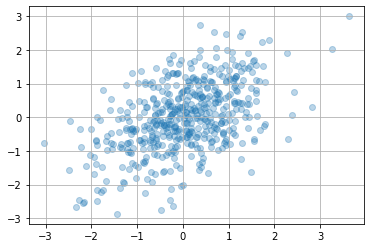

In [25]:
plt.scatter(all_samples_cat[:, 0], all_samples_cat[:, 1], alpha=0.3)
plt.grid()

## SGHMC

In [22]:
from bnn_hmc.core import sgmcmc

In [23]:
lr = 1.e-2
mom = 0.95
lr_schedule = train_utils.make_cosine_lr_schedule_with_burnin(lr, lr, 1)
optimizer = sgmcmc.sgld_gradient_update(lr_schedule, momentum_decay=mom, seed=0)

In [24]:
params = jnp.ones_like(mu)
opt_state = optimizer.init(params)
fake_net_state = jnp.array([jnp.nan,])

In [25]:
sgmcmc_train_epoch = train_utils.make_sgd_train_epoch(
    fake_net_apply, log_likelihood_fn, log_prior_fn, optimizer, num_batches=1)

In [26]:
num_iterations = 10000
num_devices = 1
all_samples = []
key = jax.random.PRNGKey(0)
key = jax.random.split(key, num_devices)
save_freq = 10

for iteration in tqdm.tqdm(range(num_iterations)):
    params, _, opt_state, logprob_avg, key = sgmcmc_train_epoch(
        params, fake_net_state, opt_state, fake_data, key)
    if iteration % save_freq == 0:
        all_samples.append(onp.asarray(params).copy())

100%|██████████| 10000/10000 [00:11<00:00, 880.26it/s]


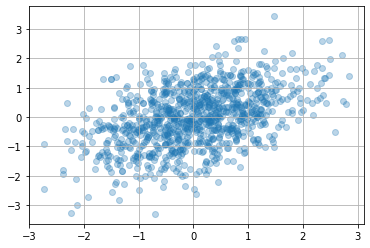

In [27]:
all_samples_cat = onp.stack(all_samples)
plt.scatter(all_samples_cat[:, 0], all_samples_cat[:, 1], alpha=0.3)
plt.grid()


## SGLD

In [29]:
lr = 1.e-2
mom = 0.
lr_schedule = train_utils.make_cosine_lr_schedule_with_burnin(lr, lr, 1)
optimizer = sgmcmc.sgld_gradient_update(lr_schedule, momentum_decay=mom, seed=0)

In [30]:
params = jnp.ones_like(mu)
opt_state = optimizer.init(params)
fake_net_state = jnp.array([jnp.nan,])

In [31]:
sgmcmc_train_epoch = train_utils.make_sgd_train_epoch(
    fake_net_apply, log_likelihood_fn, log_prior_fn, optimizer, num_batches=1)

In [32]:
num_iterations = 10000
num_devices = 1
all_samples = []
key = jax.random.PRNGKey(0)
key = jax.random.split(key, num_devices)
save_freq = 10

for iteration in tqdm.tqdm(range(num_iterations)):
    params, _, opt_state, logprob_avg, key = sgmcmc_train_epoch(
        params, fake_net_state, opt_state, fake_data, key)
    if iteration % save_freq == 0:
        all_samples.append(onp.asarray(params).copy())

100%|██████████| 10000/10000 [00:11<00:00, 908.02it/s]


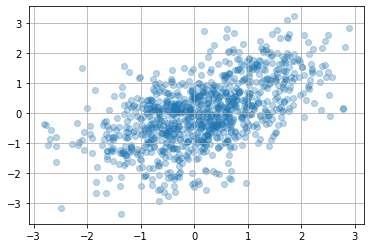

In [33]:
all_samples_cat = onp.stack(all_samples)
plt.scatter(all_samples_cat[:, 0], all_samples_cat[:, 1], alpha=0.3)
plt.grid()

## SGHMC with RMSprop Preconditioner

In [37]:
lr = 1.e-2
mom = 0.95
lr_schedule = train_utils.make_cosine_lr_schedule_with_burnin(lr, lr, 1)
preconditioner = sgmcmc.get_rmsprop_layerwise_preconditioner()
optimizer = sgmcmc.sgld_gradient_update(lr_schedule, momentum_decay=mom, seed=0, preconditioner=preconditioner)

In [38]:
params = jnp.ones_like(mu)
opt_state = optimizer.init(params)
fake_net_state = jnp.array([jnp.nan,])

In [39]:
sgmcmc_train_epoch = train_utils.make_sgd_train_epoch(
    fake_net_apply, log_likelihood_fn, log_prior_fn, optimizer, num_batches=1)

In [40]:
num_iterations = 10000
num_devices = 1
all_samples = []
key = jax.random.PRNGKey(0)
key = jax.random.split(key, num_devices)
save_freq = 10

for iteration in tqdm.tqdm(range(num_iterations)):
    params, _, opt_state, logprob_avg, key = sgmcmc_train_epoch(
        params, fake_net_state, opt_state, fake_data, key)
    if iteration % save_freq == 0:
        all_samples.append(onp.asarray(params).copy())

100%|██████████| 10000/10000 [00:12<00:00, 828.16it/s]


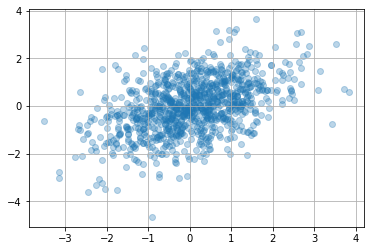

In [44]:
all_samples_cat = onp.stack(all_samples)
plt.scatter(all_samples_cat[:, 0], all_samples_cat[:, 1], alpha=0.3)
plt.grid()